In [ ]:
import os
import sys
import glob
import random
import cv2 as cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
sys.setrecursionlimit(1000000)
plt.rc('image', cmap='binary_r')

In [ ]:
!unzip "/content/drive/MyDrive/sem 8/CV/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: shapes/star/3234.png    
  inflating: shapes/star/3235.png    
  inflating: shapes/star/3236.png    
  inflating: shapes/star/3237.png    
  inflating: shapes/star/3238.png    
  inflating: shapes/star/3239.png    
  inflating: shapes/star/324.png     
  inflating: shapes/star/3240.png    
  inflating: shapes/star/3241.png    
  inflating: shapes/star/3242.png    
  inflating: shapes/star/3243.png    
  inflating: shapes/star/3244.png    
  inflating: shapes/star/3245.png    
  inflating: shapes/star/3246.png    
  inflating: shapes/star/3247.png    
  inflating: shapes/star/3248.png    
  inflating: shapes/star/3249.png    
  inflating: shapes/star/325.png     
  inflating: shapes/star/3250.png    
  inflating: shapes/star/3251.png    
  inflating: shapes/star/3252.png    
  inflating: shapes/star/3253.png    
  inflating: shapes/star/3254.png    
  inflating: shapes/star/3255.png    
  inflating: shapes/star/3256.png    

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Approach 1
- Using Shape Factor Only
  where Shape_factor = area / (diameter ** 2)
  
  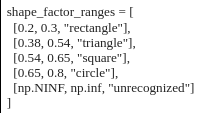

In [ ]:
categories = ["circle", "square", "star", "triangle"]
# categories = ["circle", "square", "triangle"]

im_width = 200
im_height = 200

In [ ]:
def gaussian_filter(img, mask_size = 5, sigma = 2):
  offset = mask_size // 2
  x, y = np.meshgrid(range(-offset, offset + 1), range(-offset, offset + 1))
  gauss_filter = np.exp(-((x ** 2 + y ** 2) / (2 * sigma ** 2)))
  gauss_filter /= gauss_filter.sum()
  return cv2.filter2D(src = img, ddepth = -1, kernel = gauss_filter)

In [ ]:
data = []
target = []

for cat in categories:
    filelist = glob.glob('/content/shapes/' + cat + '/*.png')
    target.extend([cat for _ in filelist])
    data.extend([gaussian_filter(np.array(Image.open(fname).resize((im_width, im_height))), mask_size = 9, sigma=20) for fname in filelist])

data_array = np.stack(data, axis=0)

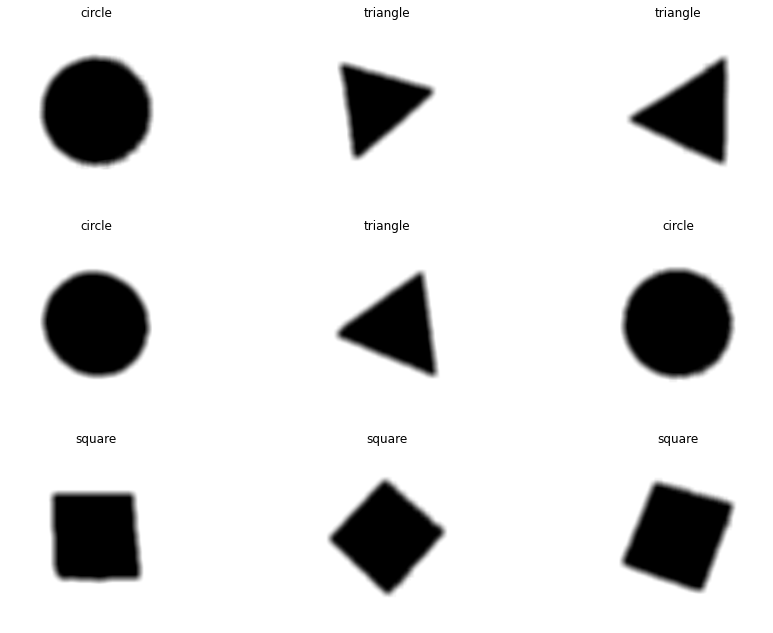

In [ ]:
fig = plt.figure(figsize=(20,15))
gs = fig.add_gridspec(4, 4)

for line in range(0, 3):
    for row in range(0, 3):
        num_image = random.randint(0, data_array.shape[0])
        ax = fig.add_subplot(gs[line, row])
        ax.axis('off');
        ax.set_title(target[num_image])
        ax.imshow(data_array[num_image]);

In [ ]:
shape_factor_ranges = [
  [0.2, 0.3, "rectangle"], 
  [0.38, 0.54, "triangle"], 
  [0.54, 0.65, "square"], 
  [0.65, 0.8, "circle"], 
  [np.NINF, np.inf, "unrecognized"]
]

In [ ]:
black = 0
white = 1

dx = [0, 0, 1, -1]
dy = [1, -1, 0, 0]

def dfs(i, j, img, visited, im_height=25, im_width=25):
  visited.append((i, j))
  img[i, j] = white
  cnt = 1
  for k in range(4):
    ix = i + dx[k]
    jy = j + dy[k]

    if ix < 0 or ix >= im_height or jy < 0 or jy >= im_width:
      continue

    if (img[ix, jy] == black):
      cnt += dfs(ix, jy, img, visited)
  return cnt

In [ ]:
def calculate_shape_factor(area, diameter):
  return area / (diameter ** 2)

In [ ]:
def find_max_dist(visited):
  max_dist = np.NINF
  for i in visited:
    for j in visited:
      dist = (i[0] - j[0]) ** 2 + (i[1] - j[1]) ** 2
      max_dist = max(max_dist, dist)
  return (max_dist ** 0.5)

In [ ]:
def detect_shapes(given_img, im_height=25, im_width=25):
  detected_shape = dict()
  img = np.array(given_img)
  for i in range(im_height):
    for j in range(im_width):
      if img[i, j] == black:
        visited = []
        area = dfs(i, j, img, visited)
        diameter = find_max_dist(visited)
        if diameter == 0:
          continue
        shape_factor = calculate_shape_factor(area, diameter)
        for shape_info in shape_factor_ranges:
          if shape_factor >= shape_info[0] and shape_factor <= shape_info[1]:
            detected_shape[(i, j)] = [shape_factor, shape_info[2]]
            break
  return detected_shape

In [ ]:
dict_index = {"circle": 0, "square": 0, "triangle": 0, "star": 0}
show_imgs = False

y_pred = []
y_test = []

correct_cnt = 0
total_tst = 0
total_cnt = 100


#def func(img):
for idx, image in enumerate(data_array):
  if idx >= total_cnt: break

  rand_idx = random.randint(0, len(data_array))

  image = data_array[rand_idx]
  img_copy = image.copy()

  #gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
  
  """Otsu’s thresholding attempts to be dynamic and automatically computes the 
  optimal threshold value based on the input image."""
  thresh = cv2.threshold(img_copy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  
  # Find contours, obtain bounding box, extract and save ROI (Region of Interest)
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  ROI = []
  for c in contours:
      offset = 5
      x,y,w,h = cv2.boundingRect(c)
      x = x-offset
      y = y-offset
      w += 2*offset
      h += 2*offset
      ROI = cv2.resize(thresh[y:y+h, x:x+w], (25,25), interpolation = cv2.INTER_AREA)
      
  thres, img = cv2.threshold(ROI, 50, 255, cv2.THRESH_BINARY);
  #plt.imshow(img, cmap = "binary"), plt.show();
  img = img/img.max()
  #print(img)

  shape = detect_shapes(img)
  y_pred.append(shape.values())
  y_test.append(target[rand_idx])
  
  if y_test[-1] == "star":
    continue

  correct_cnt += (list(y_pred[-1])[0][1] == y_test[-1])
  total_tst += 1
  print("actual:", target[rand_idx], ", predicted: ",y_pred[-1])

  if show_imgs:
    plt.title(f"actual: {target[rand_idx]}, predicted: {y_pred[-1]}")
    plt.imshow(img, cmap = 'binary_r')
    plt.show()
  else:
    print("\b" * prev_length)
    print(f"\b{i}")
    prev_length = len(str(i)) + 1  

print("accuracy: ", correct_cnt / total_tst)

actual: circle , predicted:  dict_values([[0.7799145299145298, 'circle']])

42
actual: circle , predicted:  dict_values([[0.7101167315175098, 'circle']])

42
actual: square , predicted:  dict_values([[0.5461538461538461, 'square']])

42
actual: triangle , predicted:  dict_values([[0.49900990099009906, 'triangle']])

42
actual: square , predicted:  dict_values([[0.5420792079207921, 'square']])

42
actual: square , predicted:  dict_values([[0.5977528089887639, 'square']])

42
actual: triangle , predicted:  dict_values([[0.5257510729613735, 'triangle']])

42
actual: square , predicted:  dict_values([[0.5619223659889093, 'square']])

42
actual: triangle , predicted:  dict_values([[0.5131845841784989, 'triangle']])

42
actual: square , predicted:  dict_values([[0.5362499999999999, 'triangle']])

42
actual: triangle , predicted:  dict_values([[0.5093555093555093, 'triangle']])

42
actual: square , predicted:  dict_values([[0.6080178173719376, 'squa

Done Approach 1


In [ ]:
# Creating CSV Data

In [ ]:
dict_index = {"circle": 0, "square": 0, "triangle": 0, "star": 0}

processed_imgs = []

for idx, image in enumerate(data_array):

  image = data_array[idx]  
  img_copy = image.copy()

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  """Otsu’s thresholding attempts to be dynamic and automatically computes the 
  optimal threshold value based on the input image."""
  thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  
  # Find contours, obtain bounding box, extract and save ROI (Region of Interest)
  ROI_number = 0
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  
  blank = np.zeros(thresh.shape)

  cv2.drawContours(blank, contours, -1, (255, 0, 0), 1)

  ROI = []

  for c in contours:
      offset = 5
      x,y,w,h = cv2.boundingRect(c)
      x = x-offset
      y = y-offset
      w += 2*offset
      h += 2*offset
      ROI = cv2.resize(thresh[y:y+h, x:x+w], (50,50), interpolation = cv2.INTER_AREA)
      ROI = cv2.Canny(ROI,1,1)
      ROI_number += 1

  ROI = ROI/255
  processed_imgs.append(ROI.flatten())

In [ ]:
df = pd.DataFrame(data=processed_imgs)

In [ ]:
final_df = df.assign(target=target)

In [ ]:
final_df = final_df[final_df.target != "sta"]

In [ ]:
final_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,target
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cir
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cir
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,squ
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hep
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,squ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,tri
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,pen
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,cir
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,non


In [ ]:
final_df['target'].value_counts()

pen    3410
non    3393
hex    3357
oct    3351
cir    3339
squ    3280
hep    3264
tri    3235
Name: target, dtype: int64

In [ ]:
final_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624
count,8903.0,8903.0,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.0,8903.0,8903.0,8903.0,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,...,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.0,8903.0,8903.0,8903.000000,8903.0,8903.0,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.000000,8903.0,8903.0,8903.0,8903.0,8903.0
mean,0.0,0.0,0.000112,0.000337,0.000337,0.000337,0.000449,0.002808,0.004268,0.006739,0.013366,0.021341,0.028417,0.022689,0.014153,0.008536,0.003931,0.002696,0.000449,0.000225,0.000225,0.000225,0.0,0.0,0.0,0.0,0.013479,0.017073,0.022464,0.022464,0.030664,0.065821,0.146355,0.246658,0.324385,0.387734,0.434460,0.453780,0.442098,0.393014,...,0.393014,0.444906,0.474896,0.438616,0.389082,0.325845,0.240031,0.137482,0.065821,0.032349,0.023588,0.025497,0.019319,0.016062,0.0,0.0,0.0,0.000337,0.0,0.0,0.000225,0.000337,0.001573,0.002583,0.004268,0.006178,0.013142,0.005616,0.014939,0.006739,0.002808,0.002134,0.001797,0.000225,0.000225,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.010598,0.018355,0.018355,0.018355,0.021193,0.052919,0.065196,0.081821,0.114844,0.144527,0.166171,0.148918,0.118126,0.092003,0.062580,0.051853,0.021193,0.014987,0.014987,0.014987,0.0,0.0,0.0,0.0,0.115319,0.129550,0.148196,0.148196,0.172415,0.247982,0.353482,0.431090,0.468171,0.487261,0.495714,0.497887,0.496664,0.488447,...,0.488447,0.496983,0.499397,0.496246,0.487569,0.468716,0.427126,0.344375,0.247982,0.176934,0.151769,0.157638,0.137653,0.125721,0.0,0.0,0.0,0.018355,0.0,0.0,0.014987,0.018355,0.039626,0.050764,0.065196,0.078360,0.113888,0.074734,0.121315,0.081821,0.052919,0.046150,0.042357,0.014987,0.014987,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000

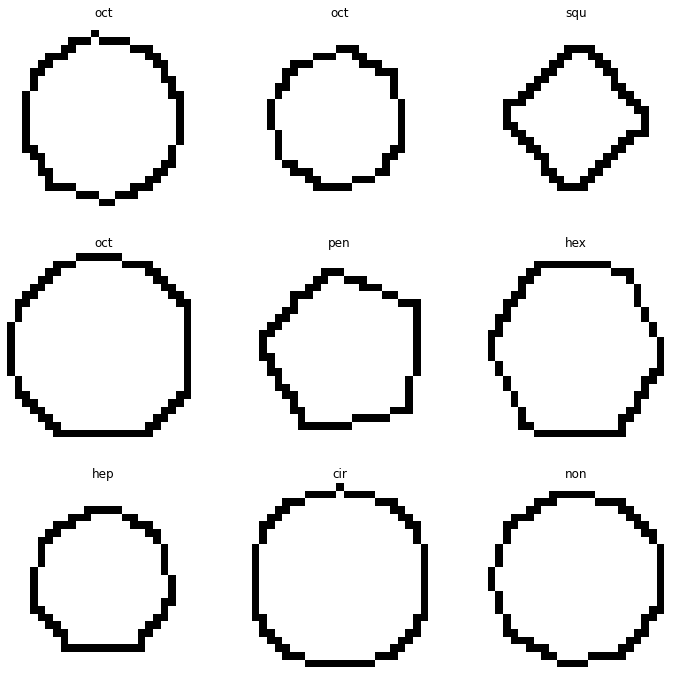

In [ ]:
rows = 3
cols = 3

plt.figure(figsize = (cols * 4, rows * 4))
# random_indices = np.random.randint(low = 0, high = dataset.shape[0], size = rows * cols)
# pred = clf.predict(dataset.iloc[idx, :-1])

for i in range(rows * cols):
  idx = random.randint(0, final_df.shape[0])
  img = final_df.iloc[idx, :-1].to_numpy().reshape(25, 25).astype(int)
  plt.subplot(rows, cols, i + 1), plt.axis("off")
  # plt.title(f"true: {final_df.iloc[idx, -1]}, pred: {pred}")
  plt.title(f"{final_df.iloc[idx, -1]}")
  plt.imshow(img, cmap = "binary")
  
plt.show();

In [ ]:
final_df.to_csv('shapes3.csv')

In [ ]:
!cp "/content/shapes3.csv" "/content/drive/MyDrive/sem 8/CV/"